comment ca marche ? 
j'utilise spacy 
dans spacy on a :

    - un tokenizer : decoupe le texte 
    
    - pipeline

    - Embeddings ( tok2vec ou camemBert ) 
    
    - NER ( =? consommateur d'embeddings )  -> choose whre dep , arr, o 

is spacy the tokenizer and ner ?  yes

    nlp.pipe_names
    # ['tok2vec', 'ner']
    
on peut apres faire spacy + camemBert 


    nlp.pipe_names    
    # ['transformer', 'ner']

( camembert utilise des embeddings ) 
embeddings ???? 

on peut laisser spacy faire des tokens, puis appeler un transformer dans spacy, 
    le transformer utilise les tokens de spacy avec les embeddings de camembert 



spaCy	:   Pipeline, objets, entraînement, NER

spaCy :   tokenizer	Découpe du texte

CamemBERT	:   Produit les vecteurs

spaCy NER	:   Décide Dep / Arr

IOB	:   Format de sortie




In [1]:
import json
from datasets import Dataset
import spacy 

In [8]:
with open("../data/dataset_ner_cities_split.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [9]:

train_dataset = Dataset.from_list(data["train"])
val_dataset   = Dataset.from_list(data["val"])

In [5]:
text = "je veux aller de rouen a paris" 
nlp = spacy.load("fr_core_news_sm")

doc = nlp(text)

[(token.text, token.idx) for token in doc ]

[('je', 0),
 ('veux', 3),
 ('aller', 8),
 ('de', 14),
 ('rouen', 17),
 ('a', 23),
 ('paris', 25)]

--> spacy fait le tokenizer, sans comprendre le texte 

In [14]:
## adding ner : 
# error 007 ner = nlp.add_pipe("ner") 

# ['tok2vec', 'morphologizer', 'parser', 'senter',
#  'attribute_ruler', 'lemmatizer', 'ner']

#( cant add ner to spacy.load ( already has ner )) 

In [15]:
doc.ents

(rouen, paris)

In [16]:
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

# apprendre les dep / arr 
--> import data with dep arr annotations 

In [5]:
import random
from spacy.util import minibatch, compounding


import spacy
from spacy.util import minibatch, compounding
import random
import json

from spacy.training import Example


In [11]:
with open("../data/dataset_spacy_dep_arr.json", "r", encoding="utf-8") as f:
    data_spacy = json.load(f)   

In [12]:
train_data_spacy = data_spacy["train"]
val_data_spacy = data_spacy["val"]

In [12]:
print(f"Train size: {len(train_data_spacy)}")

Train size: 6000


In [8]:
ner = nlp.get_pipe("ner")


In [9]:
ner.add_label("DEP")
ner.add_label("ARR")

1

In [13]:
# On désactive les autres composants pendant l'entraînement
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    
    for itn in range(20):  # nombre d'itérations
        random.shuffle(train_data_spacy)
        losses = {}
        # spaCy utilise minibatch pour gérer les tailles
        batches = minibatch(train_data_spacy, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            examples = []
            for text, annot in batch:
                doc = nlp.make_doc(text)
                examples.append(Example.from_dict(doc, annot))
            nlp.update(examples, drop=0.2, sgd=optimizer, losses=losses)
        print(f"Iteration {itn}, Losses: {losses}")



Iteration 0, Losses: {'ner': np.float32(4229.7427)}
Iteration 1, Losses: {'ner': np.float32(172.91075)}
Iteration 2, Losses: {'ner': np.float32(110.44875)}
Iteration 3, Losses: {'ner': np.float32(69.48374)}
Iteration 4, Losses: {'ner': np.float32(37.161453)}
Iteration 5, Losses: {'ner': np.float32(29.036968)}
Iteration 6, Losses: {'ner': np.float32(32.796806)}
Iteration 7, Losses: {'ner': np.float32(45.92224)}
Iteration 8, Losses: {'ner': np.float32(23.741238)}
Iteration 9, Losses: {'ner': np.float32(4.7230697)}
Iteration 10, Losses: {'ner': np.float32(36.48762)}
Iteration 11, Losses: {'ner': np.float32(36.213017)}
Iteration 12, Losses: {'ner': np.float32(12.655683)}
Iteration 13, Losses: {'ner': np.float32(37.814583)}
Iteration 14, Losses: {'ner': np.float32(22.06298)}
Iteration 15, Losses: {'ner': np.float32(15.949794)}
Iteration 16, Losses: {'ner': np.float32(20.171236)}
Iteration 17, Losses: {'ner': np.float32(15.28213)}
Iteration 18, Losses: {'ner': np.float32(5.198355)}
Iteration

In [23]:
text_test = "pour aller à Lyon depuis clermont ferrand le lundi"

doc = nlp(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lyon ARR


In [6]:
from spacy.scorer import Scorer
from spacy.training import Example

def evaluate_ner_easy(nlp, dataset):
    scorer = Scorer()
    examples = []
    
    for text, annot in dataset:
        pred_doc = nlp(text)
        example = Example.from_dict(pred_doc, annot)
        examples.append(example)
    
    scores = scorer.score(examples)
    
    print(f"Precision: {scores['ents_p']:.4f}")
    print(f"Recall   : {scores['ents_r']:.4f}")
    print(f"F1-score : {scores['ents_f']:.4f}")
    
    return scores['ents_p'], scores['ents_r'], scores['ents_f']

In [15]:
evaluate_ner_easy(nlp, val_data_spacy)

Precision: 0.9737
Recall   : 0.9809
F1-score : 0.9772


(0.9736519607843137, 0.9808641975308642, 0.9772447724477246)

In [ ]:
loss n'est pas décroissante ! 
ptit probleme de convergence ? 
comment prevent ? 

proposition : 
    lower drop 
    plus d ITERATION ? 

aussi : probleme de clermont-ferrand sans - 
rq : je peux ajouter des villes sans MAJUSCULE , sinon travailler le tout en lowercase 

In [ ]:
## new dataset with upper and lowercase
##  trying the same nlp 

In [2]:
with open("../data/dataset_spacy_dep_arr_MAJUSCULE.json", "r", encoding="utf-8") as f:
    data_spacy_MAJ = json.load(f)   
train_data_spacy_MAJ = data_spacy_MAJ["train"]
val_data_spacy_MAJ = data_spacy_MAJ["val"]

In [3]:
print(f"Train size: {len(train_data_spacy_MAJ)}")

Train size: 6000


In [17]:
nlp1 = spacy.load("fr_core_news_sm")
ner1 = nlp1.get_pipe("ner")
ner1.add_label("DEP")
ner1.add_label("ARR")

1

In [38]:
# pour moins de repetion train functuion 
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
#! pip install matplotlib 
import matplotlib.pyplot as plt

def train_ner(nlp, train_data, n_iter=20, dropout=0.2):
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    loss_history = []  

    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()

        for itn in range(n_iter):
            random.shuffle(train_data)
            losses = {}
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))

            for batch in batches:
                examples = []
                for text, annot in batch:
                    doc = nlp.make_doc(text)
                    examples.append(Example.from_dict(doc, annot))

                nlp.update(examples, drop=dropout, sgd=optimizer, losses=losses)
            
            # Store the NER loss for this iteration
            loss_history.append(losses.get("ner"))
            print(f"Iteration {itn} complete", end="\r") 

    plt.figure(figsize=(5, 3)) # Small size
    plt.plot(loss_history[5:], color='#1f77b4', linewidth=2)
    plt.title("NER Training Loss", fontsize=10)
    plt.xlabel("Iteration", fontsize=8)
    plt.ylabel("Loss", fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return nlp


In [18]:
nlp1 = train_ner(nlp1, train_data_spacy_MAJ, n_iter=20, dropout=0.2)

Iteration 0, Losses: {'ner': np.float32(5070.2334)}
Iteration 1, Losses: {'ner': np.float32(244.66103)}
Iteration 2, Losses: {'ner': np.float32(158.17766)}
Iteration 3, Losses: {'ner': np.float32(93.76734)}
Iteration 4, Losses: {'ner': np.float32(75.988)}
Iteration 5, Losses: {'ner': np.float32(52.615654)}
Iteration 6, Losses: {'ner': np.float32(37.280273)}
Iteration 7, Losses: {'ner': np.float32(56.11752)}
Iteration 8, Losses: {'ner': np.float32(28.322815)}
Iteration 9, Losses: {'ner': np.float32(12.107591)}
Iteration 10, Losses: {'ner': np.float32(19.815214)}
Iteration 11, Losses: {'ner': np.float32(30.283726)}
Iteration 12, Losses: {'ner': np.float32(16.350319)}
Iteration 13, Losses: {'ner': np.float32(27.364088)}
Iteration 14, Losses: {'ner': np.float32(116.712524)}
Iteration 15, Losses: {'ner': np.float32(51.71079)}
Iteration 16, Losses: {'ner': np.float32(18.85109)}
Iteration 17, Losses: {'ner': np.float32(33.94781)}
Iteration 18, Losses: {'ner': np.float32(18.93853)}
Iteration 1

In [20]:
evaluate_ner_easy(nlp1, val_data_spacy_MAJ)

Precision: 0.9686
Recall   : 0.9752
F1-score : 0.9719


(0.9686262564727384, 0.9751609935602575, 0.9718826405867971)

## pas de vrai changement apres avoir ajouter les lower case. 
## les resultats sont tres  bien -> je pense que ca overfit 



-------> 
lets try lower dropout 

In [22]:
nlp2 = spacy.load("fr_core_news_sm")
ner2 = nlp2.get_pipe("ner")
ner2.add_label("DEP")
ner2.add_label("ARR")

nlp2 = train_ner(nlp2, train_data_spacy_MAJ, n_iter=20, dropout=0.05)

print("\nRésultats pour NLP2 :")
metrics_nlp2 = evaluate_ner_easy(nlp2, val_data_spacy_MAJ)
ration 16, Losses: {'ner': np.float32(7.8717413)}
Iteration 17, Losses: {'ner': np.float32(53.32335)}
Iteration 18, Losses: {'ner': np.float32(17.595816)}
Iteration 19, Losses: {'ner': np.float32(10.94349)}

Résultats pour NLP2 :
Precision: 0.9633
Recall   : 0.9749
F1-score : 0.9691


Iteration 0, Losses: {'ner': np.float32(3707.1628)}
Iteration 1, Losses: {'ner': np.float32(140.14496)}
Iteration 2, Losses: {'ner': np.float32(33.39385)}
Iteration 3, Losses: {'ner': np.float32(26.808626)}
Iteration 4, Losses: {'ner': np.float32(42.832752)}
Iteration 5, Losses: {'ner': np.float32(22.289032)}
Iteration 6, Losses: {'ner': np.float32(48.53409)}
Iteration 7, Losses: {'ner': np.float32(64.83172)}
Iteration 8, Losses: {'ner': np.float32(19.248617)}
Iteration 9, Losses: {'ner': np.float32(28.098274)}
Iteration 10, Losses: {'ner': np.float32(11.672596)}
Iteration 11, Losses: {'ner': np.float32(35.24946)}
Iteration 12, Losses: {'ner': np.float32(17.815327)}
Iteration 13, Losses: {'ner': np.float32(13.227271)}
Iteration 14, Losses: {'ner': np.float32(4.251821)}
Iteration 15, Losses: {'ner': np.float32(13.629897)}
Iteration 16, Losses: {'ner': np.float32(7.8717413)}
Iteration 17, Losses: {'ner': np.float32(53.32335)}
Iteration 18, Losses: {'ner': np.float32(17.595816)}
Iteration

Iteration 39 complete

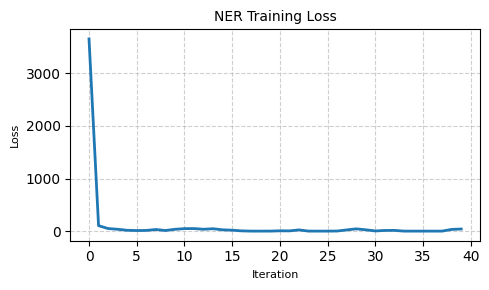


Résultats pour NLP3 :
Precision: 0.9701
Recall   : 0.9736
F1-score : 0.9718


In [27]:
nlp3 = spacy.load("fr_core_news_sm")
ner3 = nlp3.get_pipe("ner")
ner3.add_label("DEP")
ner3.add_label("ARR")

nlp3 = train_ner(nlp3, train_data_spacy_MAJ, n_iter=40, dropout=0.05)

print("\nRésultats pour NLP3 :")
metrics_nlp3 = evaluate_ner_easy(nlp3, val_data_spacy_MAJ)

In [29]:
text_test = "pour aller à Lyon depuis clermont-ferrand le lundi"

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lyon ARR
clermont-ferrand le lundi DEP


In [34]:
text_test = "pour aller à Lyon depuis clermont ferrand, le lundi"

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lyon ARR
clermont ferrand DEP
le lundi ARR


In [35]:
text_test = "pour aller à Lyon depuis clermont-ferrand, le lundi"

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lyon ARR
clermont-ferrand DEP
le lundi ARR


In [36]:
text_test = "je veux aler de lille jusqua marseille "

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

lille DEP


In [37]:
text_test = "je veux aler de Lille jusqua MArseille "

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lille DEP


Right now:
Context strongly signals the label.

Instead, create sentences like:

Rouen est plus petit que Paris
Je préfère Paris à Rouen
Entre Paris et Rouen il y a du vent
Rouen ou Paris, je ne sais pas


Now:

Position no longer defines label.

Model must learn contextual meaning.

In [11]:
# je changais les parameters fdu pre trianed ner 
# pour moins de repetion train functuion 
## donc resume traingin pas begin_trianing 

from spacy.training import Example
from spacy.util import minibatch, compounding
import random
#! pip install matplotlib 
import matplotlib.pyplot as plt

def train_ner(nlp, train_data, n_iter=20, dropout=0.2):
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    loss_history = []  

    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.resume_training()

        for itn in range(n_iter):
            random.shuffle(train_data)
            losses = {}
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))

            for batch in batches:
                examples = []
                for text, annot in batch:
                    doc = nlp.make_doc(text)
                    examples.append(Example.from_dict(doc, annot))

                nlp.update(examples, drop=dropout, sgd=optimizer, losses=losses)
            
            # Store the NER loss for this iteration
            loss_history.append(losses.get("ner"))
            print(f"Iteration {itn} complete", end="\r") 

    plt.figure(figsize=(5, 3)) # Small size
    plt.plot(loss_history[5:], color='#1f77b4', linewidth=2)
    plt.title("NER Training Loss", fontsize=10)
    plt.xlabel("Iteration", fontsize=8)
    plt.ylabel("Loss", fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return nlp
 

Iteration 39 complete

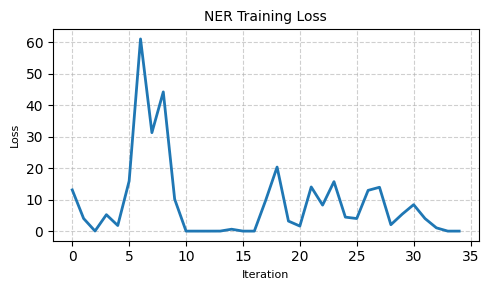


Résultats pour NLP4 :
Precision: 0.9663
Recall   : 0.9752
F1-score : 0.9707


In [40]:
nlp4 = spacy.load("fr_core_news_sm")
ner4 = nlp4.get_pipe("ner")
ner4.add_label("DEP")
ner4.add_label("ARR")

nlp4 = train_ner(nlp4, train_data_spacy_MAJ, n_iter=40, dropout=0.05)

print("\nRésultats pour NLP4 :")
metrics_nlp4 = evaluate_ner_easy(nlp4, val_data_spacy_MAJ)

In [41]:
text_test = "je veux aler de Lille jusqua MArseille "

doc = nlp4(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lille DEP
MArseille ARR


In [42]:
text_test = "je veux aler de Lille jusqua MArseille ce lundi "

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lille DEP


In [43]:
text_test = "je veux aler de Lille jusqua MArseille . ce lundi "

doc = nlp3(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Lille DEP


In [51]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 47.5 MB/s  0:00:019.6 MB/s eta 0:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


Iteration 29 complete

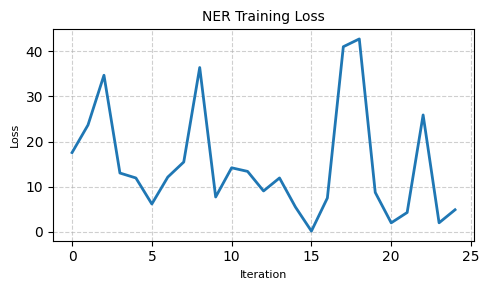


Résultats pour NLP5 :
Precision: 0.9571
Recall   : 0.9589
F1-score : 0.9580


In [54]:
import spacy 

nlp5 = spacy.load("fr_core_news_md")

if "ner" not in nlp5.pipe_names:
    ner5 = nlp5.add_pipe("ner", last=True)
else:
    ner5 = nlp5.get_pipe("ner")
    
ner5.add_label("DEP")
ner5.add_label("ARR")

nlp5 = train_ner(nlp5, train_data_spacy_MAJ, n_iter=30, dropout=0.1)

print("\nRésultats pour NLP5 :")
metrics_nlp5 = evaluate_ner_easy(nlp5, val_data_spacy_MAJ)



Iteration 19 complete

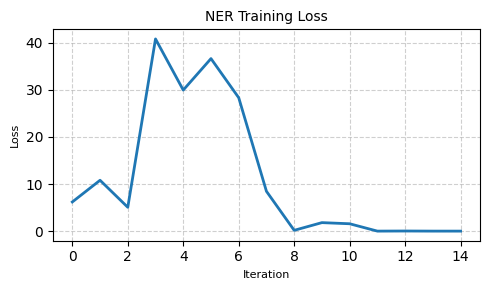


Résultats pour NLP5 :
Precision: 0.9717
Recall   : 0.9592
F1-score : 0.9654


In [55]:
nlp5 = spacy.load("fr_core_news_md")

if "ner" not in nlp5.pipe_names:
    ner5 = nlp5.add_pipe("ner", last=True)
else:
    ner5 = nlp5.get_pipe("ner")
    
ner5.add_label("DEP")
ner5.add_label("ARR")

nlp5 = train_ner(nlp5, train_data_spacy_MAJ, n_iter=20, dropout=0.05)

print("\nRésultats pour NLP5 :")
metrics_nlp5 = evaluate_ner_easy(nlp5, val_data_spacy_MAJ)



Iteration 39 complete

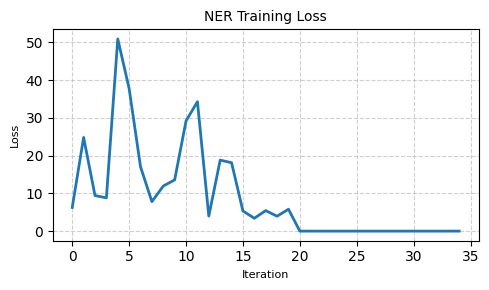


Résultats pour NLP5 :
Precision: 0.9693
Recall   : 0.9586
F1-score : 0.9639


In [56]:
nlp5 = spacy.load("fr_core_news_md")

if "ner" not in nlp5.pipe_names:
    ner5 = nlp5.add_pipe("ner", last=True)
else:
    ner5 = nlp5.get_pipe("ner")
    
ner5.add_label("DEP")
ner5.add_label("ARR")

nlp5 = train_ner(nlp5, train_data_spacy_MAJ, n_iter=40, dropout=0.05)

print("\nRésultats pour NLP5 :")
metrics_nlp5 = evaluate_ner_easy(nlp5, val_data_spacy_MAJ)


Iteration 29 complete

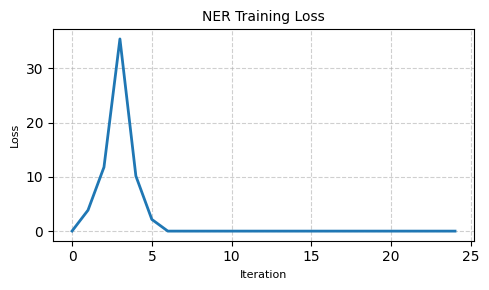


Résultats pour NLP5 :
Precision: 0.9530
Recall   : 0.9586
F1-score : 0.9558


In [60]:
nlp5 = spacy.load("fr_core_news_md")

if "ner" not in nlp5.pipe_names:
    ner5 = nlp5.add_pipe("ner", last=True)
else:
    ner5 = nlp5.get_pipe("ner")
    
ner5.add_label("DEP")
ner5.add_label("ARR")

nlp5 = train_ner(nlp5, train_data_spacy_MAJ, n_iter=30, dropout=0.03)

print("\nRésultats pour NLP5 :")
metrics_nlp5 = evaluate_ner_easy(nlp5, val_data_spacy_MAJ)


In [61]:
text_test = " je veux aller de clermontFerrand a Lille aujourdhui "

doc = nlp5(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

clermontFerrand DEP
Lille ARR


In [2]:
with open("../data/dataset_spacy_balanced_v2.json", "r", encoding="utf-8") as f:
    data_spacy_eq = json.load(f)   
train_data_spacy_eq = data_spacy_eq["train"]
val_data_spacy_eq = data_spacy_eq["val"]

Iteration 29 complete

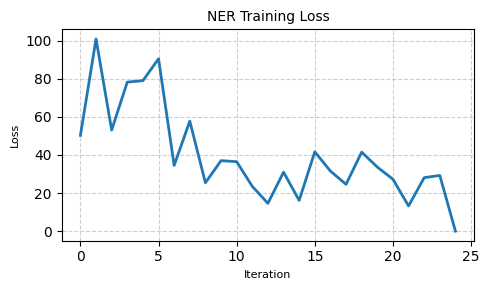


Résultats pour NLP6 :


ValueError: [E103] Trying to set conflicting doc.ents: '(18, 41, 'DEP')' and '(18, 31, 'ARR')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap. To work with overlapping entities, consider using doc.spans instead.

In [65]:
nlp6 = spacy.load("fr_core_news_md")

if "ner" not in nlp6.pipe_names:
    ner6 = nlp6.add_pipe("ner", last=True)
else:
    ner6 = nlp6.get_pipe("ner")
    
ner6.add_label("DEP")
ner6.add_label("ARR")

nlp6 = train_ner(nlp6, train_data_spacy_eq, n_iter=30, dropout=0.05)

print("\nRésultats pour NLP6 :")
metrics_nlp6 = evaluate_ner_easy(nlp6, val_data_spacy_eq)


In [67]:
print("\nRésultats pour NLP6 :")
metrics_nlp6 = evaluate_ner_easy(nlp6, val_data_spacy_eq)


Résultats pour NLP6 :
Precision: 0.9757
Recall   : 0.9690
F1-score : 0.9723


In [68]:
text_test = " je veux aller de clermontFerrand a Lille aujourdhui "

doc = nlp6(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

clermontFerrand DEP
Lille ARR


In [69]:
text_test = " jen ai marre de cette vie a Nice, emmene moi a paris fratttt "

doc = nlp6(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

cette vie DEP
Nice ARR
paris fratttt ARR


In [ ]:
## changement de la dataset, 
## use of generate_dataset_spacy-CaseVariety-Copy1 
## 20000 lignes, pas d amibuigte genre la roche et roche sur seine 


/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Petite question : je veux me trouver a Ver en vena..." with entities "[[56, 75, 'DEP'], [33, 36, 'ARR']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Iteration 39 complete

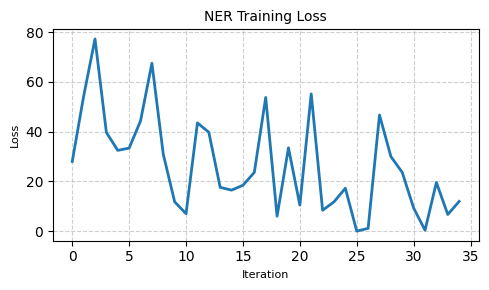


Résultats pour NLP7 :
Precision: 0.9892
Recall   : 0.9690
F1-score : 0.9790


In [8]:
nlp7 = spacy.load("fr_core_news_md")

if "ner" not in nlp7.pipe_names:
    ner7 = nlp7.add_pipe("ner", last=True)
else:
    ner7 = nlp7.get_pipe("ner")
    
ner7.add_label("DEP")
ner7.add_label("ARR")

nlp7 = train_ner(nlp7, train_data_spacy_eq, n_iter=40, dropout=0.05)

print("\nRésultats pour NLP7 :")
metrics_nlp7 = evaluate_ner_easy(nlp7, val_data_spacy_eq)

In [13]:
text_test = " jemmenez moi au bout d ela terre, emmenez moi a paris saint lazare en venant de toulouse  "

doc = nlp7(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

In [12]:
text_test = " jen ai marre de cette vie a Nice, emmene moi a paris fratttt "

doc = nlp7(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

In [14]:
text_test = " nice a rouen "

doc = nlp7(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

In [16]:
text_test = " de Nice a Rouen "

doc = nlp7(text_test)

for ent in doc.ents:
    print(ent.text, ent.label_)

Nice DEP
Rouen ARR


In [2]:
import json


with open("../data/dataset_spacy_balanced_v2_randomUP.json", "r", encoding="utf-8") as f:
    data_spacy_eq = json.load(f)   
train_data_spacy_eq = data_spacy_eq["train"]
val_data_spacy_eq = data_spacy_eq["val"]

/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Cherche un billet pour Moncontour au départ de Our..." with entities "[[19, 22, 'DEP'], [23, 33, 'ARR']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Urgent : arriver à Ur rapidement" with entities "[[0, 2, 'ARR']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Iteration 19 complete

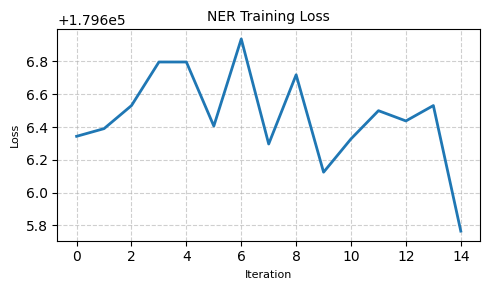


Résultats pour NLP8 (CamemBERT) :


NameError: name 'evaluate_ner_easy' is not defined

In [5]:


# je changais les parameters fdu pre trianed ner 
# pour moins de repetion train functuion 
## donc resume traingin pas begin_trianing 

from spacy.training import Example
from spacy.util import minibatch, compounding
import random
#! pip install matplotlib 
import matplotlib.pyplot as plt

def train_ner_bert(nlp, train_data, n_iter=20, dropout=0.2):
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    loss_history = []  

    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.initialize()

        for itn in range(n_iter):
            random.shuffle(train_data)
            losses = {}
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))

            for batch in batches:
                examples = []
                for text, annot in batch:
                    doc = nlp.make_doc(text)
                    examples.append(Example.from_dict(doc, annot))

                nlp.update(examples, drop=dropout, sgd=optimizer, losses=losses)
            
            # Store the NER loss for this iteration
            loss_history.append(losses.get("ner"))
            print(f"Iteration {itn} complete", end="\r") 

    plt.figure(figsize=(5, 3)) # Small size
    plt.plot(loss_history[5:], color='#1f77b4', linewidth=2)
    plt.title("NER Training Loss", fontsize=10)
    plt.xlabel("Iteration", fontsize=8)
    plt.ylabel("Loss", fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return nlp
 
import spacy
from spacy.scorer import Scorer
from spacy.training import Example

# Charger modèle transformer (CamemBERT)
nlp8 = spacy.load("fr_dep_news_trf")

# Vérifier / ajouter NER
if "ner" not in nlp8.pipe_names:
    ner8 = nlp8.add_pipe("ner", last=True)
else:
    ner8 = nlp8.get_pipe("ner")

# Ajouter labels

ner8.add_label("DEP")
ner8.add_label("ARR")

# Entraînement
nlp8 = train_ner_bert(
    nlp8,
    train_data_spacy_eq,
    n_iter=20,        # moins d'epochs qu’un CNN
    dropout=0.1       # transformer aime un peu plus de dropout
)

print("\nRésultats pour NLP8 (CamemBERT) :")
metrics_nlp8 = evaluate_ner_easy(nlp8, val_data_spacy_eq)


In [7]:


print("\nRésultats pour NLP8 (CamemBERT) :")
metrics_nlp8 = evaluate_ner_easy(nlp8, val_data_spacy_eq)



Résultats pour NLP8 (CamemBERT) :


/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Bonjour, je viens de Chaussenac pour Ens" with entities "[[21, 31, 'DEP'], [14, 17, 'ARR']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


In [1]:
import spacy
print(spacy.util.get_installed_models())


['fr_core_news_sm', 'fr_core_news_md', 'en_core_web_sm', 'fr_dep_news_trf']


Iteration 19 complete

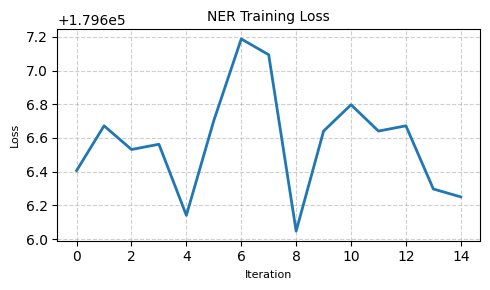


Résultats pour NLP9 (CamemBERT) :
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


In [9]:
from spacy.training import Example

# Charger modèle transformer (CamemBERT)
nlp9 = spacy.load("fr_dep_news_trf")

# Vérifier / ajouter NER
if "ner" not in nlp9.pipe_names:
    ner9 = nlp9.add_pipe("ner", last=True)
else:
    ner9 = nlp9.get_pipe("ner")

# Ajouter labels

ner9.add_label("DEP")
ner9.add_label("ARR")

# Entraînement
nlp9 = train_ner_bert(
    nlp9,
    train_data_spacy_eq,
    n_iter=20,        # moins d'epochs qu’un CNN
    dropout=0.05       # transformer aime un peu plus de dropout
)

print("\nRésultats pour NLP9 (CamemBERT) :")
metrics_nlp9 = evaluate_ner_easy(nlp9, val_data_spacy_eq)


In [14]:
print('helo')

helo


helo
Iteration 19 complete

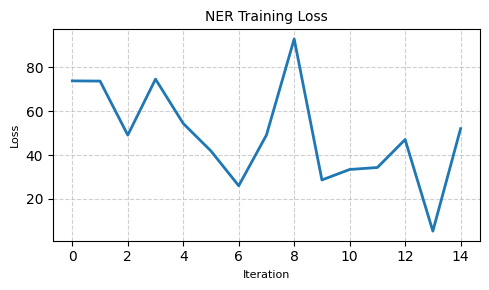


Résultats pour NLP7 :
Precision: 0.9890
Recall   : 0.9665
F1-score : 0.9777


In [15]:
print('helo')
nlp7 = spacy.load("fr_core_news_md")

if "ner" not in nlp7.pipe_names:
    ner7 = nlp7.add_pipe("ner", last=True)
else:
    ner7 = nlp7.get_pipe("ner")
    
ner7.add_label("DEP")
ner7.add_label("ARR")

nlp7 = train_ner(nlp7, train_data_spacy_eq, n_iter=20, dropout=0.05)

print("\nRésultats pour NLP7 :")
metrics_nlp7 = evaluate_ner_easy(nlp7, val_data_spacy_eq)

In [ ]:
if problermatic with dataset_eq, means the problem is in the dataset (randomUP file ) 
for that suggestion ;: change the dataset 

In [18]:
## retour au camembert , avec dataset plus simple 
import json


with open("../data/dataset_spacy_clean.json", "r", encoding="utf-8") as f:
    data_spacy_clean = json.load(f)   
train_data_spacy_clean = data_spacy_eq["train"]
val_data_spacy_clean = data_spacy_eq["val"]

Iteration 19 complete

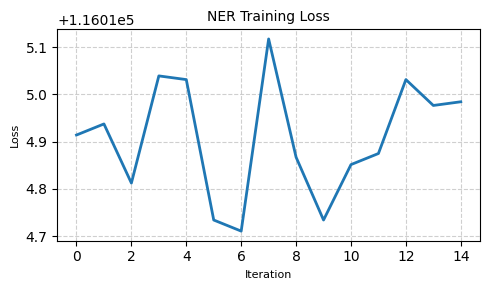


Résultats pour NLP9 (CamemBERT) :
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


In [19]:
from spacy.training import Example

# Charger modèle transformer (CamemBERT)
nlp9 = spacy.load("fr_dep_news_trf")

# Vérifier / ajouter NER
if "ner" not in nlp9.pipe_names:
    ner9 = nlp9.add_pipe("ner", last=True)
else:
    ner9 = nlp9.get_pipe("ner")

# Ajouter labels

ner9.add_label("DEP")
ner9.add_label("ARR")

# Entraînement
nlp9 = train_ner_bert(
    nlp9,
    train_data_spacy_clean,
    n_iter=20,        
    dropout=0.1       
)

print("\nRésultats pour NLP9 (CamemBERT) :")
metrics_nlp9 = evaluate_ner_easy(nlp9, val_data_spacy_clean)


In [21]:
## retour au camembert , avec dataset plus simple 
import json


with open("../data/dataset_camembert_ner.json", "r", encoding="utf-8") as f:
    data_camembert = json.load(f)   
train_data_camembert = data_camembert["train"]
val_data_camembert = data_camembert["validation"] 

In [23]:
!pip install transformers datasets evaluate seqeval

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16251 sha256=19f9a69087b0d83c029cb07c0d78c894c132c2a95c57b70c57724ce863e77bef
  Stored in directory: /home/majid/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [evaluate]


In [24]:
from transformers import CamembertTokenizerFast

In [26]:
from transformers import CamembertTokenizerFast

tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")


In [25]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []

    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)

            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            else:
                label_ids.append(-100)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [1]:
import json
import numpy as np
import evaluate
from datasets import Dataset
from transformers import (
    CamembertTokenizerFast,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer
)

# =====================================================
# LOAD DATA
# =====================================================

with open("../data/dataset_camembert_ner.json", "r", encoding="utf-8") as f:
    data_camembert = json.load(f)

train_data_camembert = data_camembert["train"]
val_data_camembert = data_camembert["validation"]

train_dataset = Dataset.from_list(train_data_camembert)
val_dataset = Dataset.from_list(val_data_camembert)

# =====================================================
# LABELS
# =====================================================

label_list = ["O", "B-DEP", "I-DEP", "B-ARR", "I-ARR"]
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:

# =====================================================
# TOKENIZER
# =====================================================

tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

# =====================================================
# ALIGN LABELS WITH SUBTOKENS
# =====================================================

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []

    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)

            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            else:
                label_ids.append(-100)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
val_dataset = val_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [3]:

# =====================================================
# MODEL
# =====================================================

model = AutoModelForTokenClassification.from_pretrained(
    "camembert-base",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)


Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:

# =====================================================
# METRICS
# =====================================================

metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]

    results = metric.compute(
        predictions=true_predictions,
        references=true_labels
    )

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [5]:
#!pip install -U transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached transformers-5.1.0-py3-none-any.whl.metadata (31 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.3 kB)
Using cached transformers-5.1.0-py3-none-any.whl (10.3 MB)
Using cached huggingface_hub-1.4.1-py3-none-any.whl (553 kB)
Using cached tokenizers-0.22.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.36.2
    Uninstalling huggingface_hub-0.36.2:
      Successfully uninstalled huggingface_hub-0.36.2
  Attempting uninstall: tokenizers━━━━━━━━━━━━━━━━━━━━ 0/3 [huggingface-hub]
    Found existing installation: tokenizers 0.19.1 0/3 [huggingface-hub]
    Uninstalling tokenizers-0.19.1:━━━━━━━━━━━━━━━ 0/3 [huggingface-hub]
      Successfully uninstalled tokenizers-0.19.1━━ 0/3 [huggingface-hub]
  Attempting uninstall: transformers0m╺━━━━━━━━━━

In [7]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)


# =====================================================
# TRAINING ARGUMENTS
# =====================================================

training_args = TrainingArguments(
    output_dir="./camembert-ner",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
)

# =====================================================
# TRAINER
# =====================================================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# =====================================================
# TRAIN
# =====================================================

trainer.train()


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.047600,0.041511,1.000000,1.000000,1.000000,1.000000
2,0.016400,0.014316,0.999849,0.999849,0.999849,0.999926
3,0.008100,0.006964,0.999849,0.999849,0.999849,0.999975
4,0.005000,0.004391,0.999849,0.999849,0.999849,0.999975
5,0.004200,0.003570,1.000000,1.000000,1.000000,1.000000


/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TrainOutput(global_step=6250, training_loss=0.04699644181013107, metrics={'train_runtime': 8570.102, 'train_samples_per_second': 11.668, 'train_steps_per_second': 0.729, 'total_flos': 1178643650620800.0, 'train_loss': 0.04699644181013107, 'epoch': 5.0})

In [8]:

# =====================================================
# FINAL EVAL
# =====================================================

metrics = trainer.evaluate()
print(metrics)


/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.003569723106920719, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 99.0134, 'eval_samples_per_second': 50.498, 'eval_steps_per_second': 3.161, 'epoch': 5.0}


In [9]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def get_confusion_matrix(trainer, val_dataset):


    # Make predictions on the eval dataset
    predictions, labels, _ = trainer.predict(val_dataset)
    
    # predictions shape: (num_examples, seq_len, num_labels)
    # take argmax to get the predicted label ids
    pred_label_ids = np.argmax(predictions, axis=2)
    
    # Flatten the predictions and labels, ignoring padding (-100)
    true_labels = []
    pred_labels = []
    
    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if labels[i][j] != -100:  # ignore padding tokens
                true_labels.append(labels[i][j])
                pred_labels.append(pred_label_ids[i][j])
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(label_list))))
    
    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
    plt.figure(figsize=(10, 10))
    disp.plot(include_values=True, xticks_rotation='vertical')
    plt.show()


/home/majid/Desktop/MS2/data/110/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


<Figure size 1000x1000 with 0 Axes>

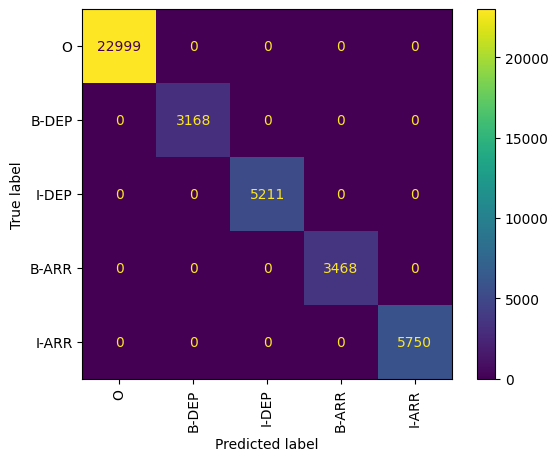

In [10]:
get_confusion_matrix(trainer,val_dataset)